# Loading and working with processed fetal Visium data - post cell2location deconvolution

In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import re
import os
import scipy.stats
from numpy import asarray as ar
from collections import Counter
import anndata as ad
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

from datetime import date
today = str(date.today())
sc.settings.verbosity = 1
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2

Running Scanpy 1.9.1, on 2023-08-10 15:10.


In [2]:
## For correct plotting of the images
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

In [3]:
# output folder 
import os
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/new_Figure3/')
os.getcwd()

'/nfs/team205/ny1/ThymusSpatialAtlas/new_Figure3'

# Explore gene expression and cytokine profiles  

AnnData object with n_obs × n_vars = 9192 × 26745
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding', 'Sequenc

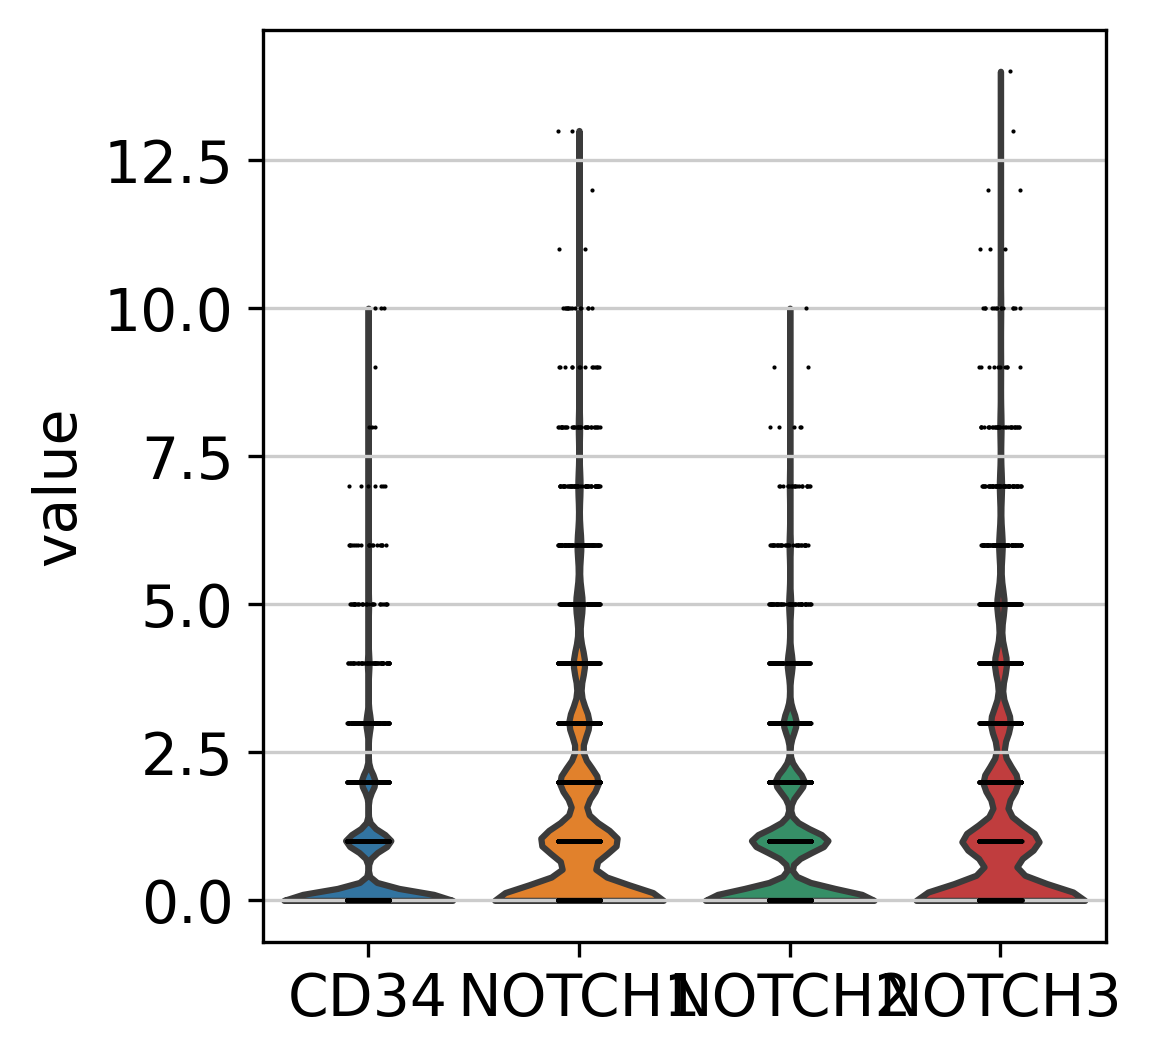

In [4]:
adata_fet_cma =  sc.read_h5ad('/nfs/team205/ny1/ThymusSpatialAtlas/Figure2/adata_fet_cma_v11.h5ad')
adata_fet_cma
# make sure it's count data 
list = ['CD34','NOTCH1','NOTCH2','NOTCH3',]
sc.pl.violin(adata_fet_cma, keys =list,layer='counts')

# correlations with axis 

Capsular= (-0.75>cma_v2)
Sub-Capsular= (-0.75<=cma_v2) & (-0.62>cma_v2)
Cortical level I= (-0.62<=cma_v2) & (-0.55>cma_v2)
Cortical level II= (-0.55<=cma_v2) & (-0.45>cma_v2)
Cortical level III= (-0.45<=cma_v2) & (-0.3>cma_v2)
Cortical CMJ= (-0.3<=cma_v2) & (0.1>cma_v2)
Medullar CMJ= (0.1<=cma_v2) & (0.55>cma_v2)
Medullar level I= (0.55<=cma_v2) & (0.65>cma_v2)
Medullar level II= (0.65<=cma_v2) & (0.7>cma_v2)
Medullar level III= (0.7=<cma_v2)


Cortical level II     1441
Capsular              1349
Cortical level I      1186
Medullar CMJ          1090
Cortical level III    1044
Medullar level I       903
Cortical CMJ           846
Medullar level II      584
Sub-Capsular           436
Medullar level III     313
Name: manual_bin_cma_v2, dtype: int64

<AxesSubplot:>

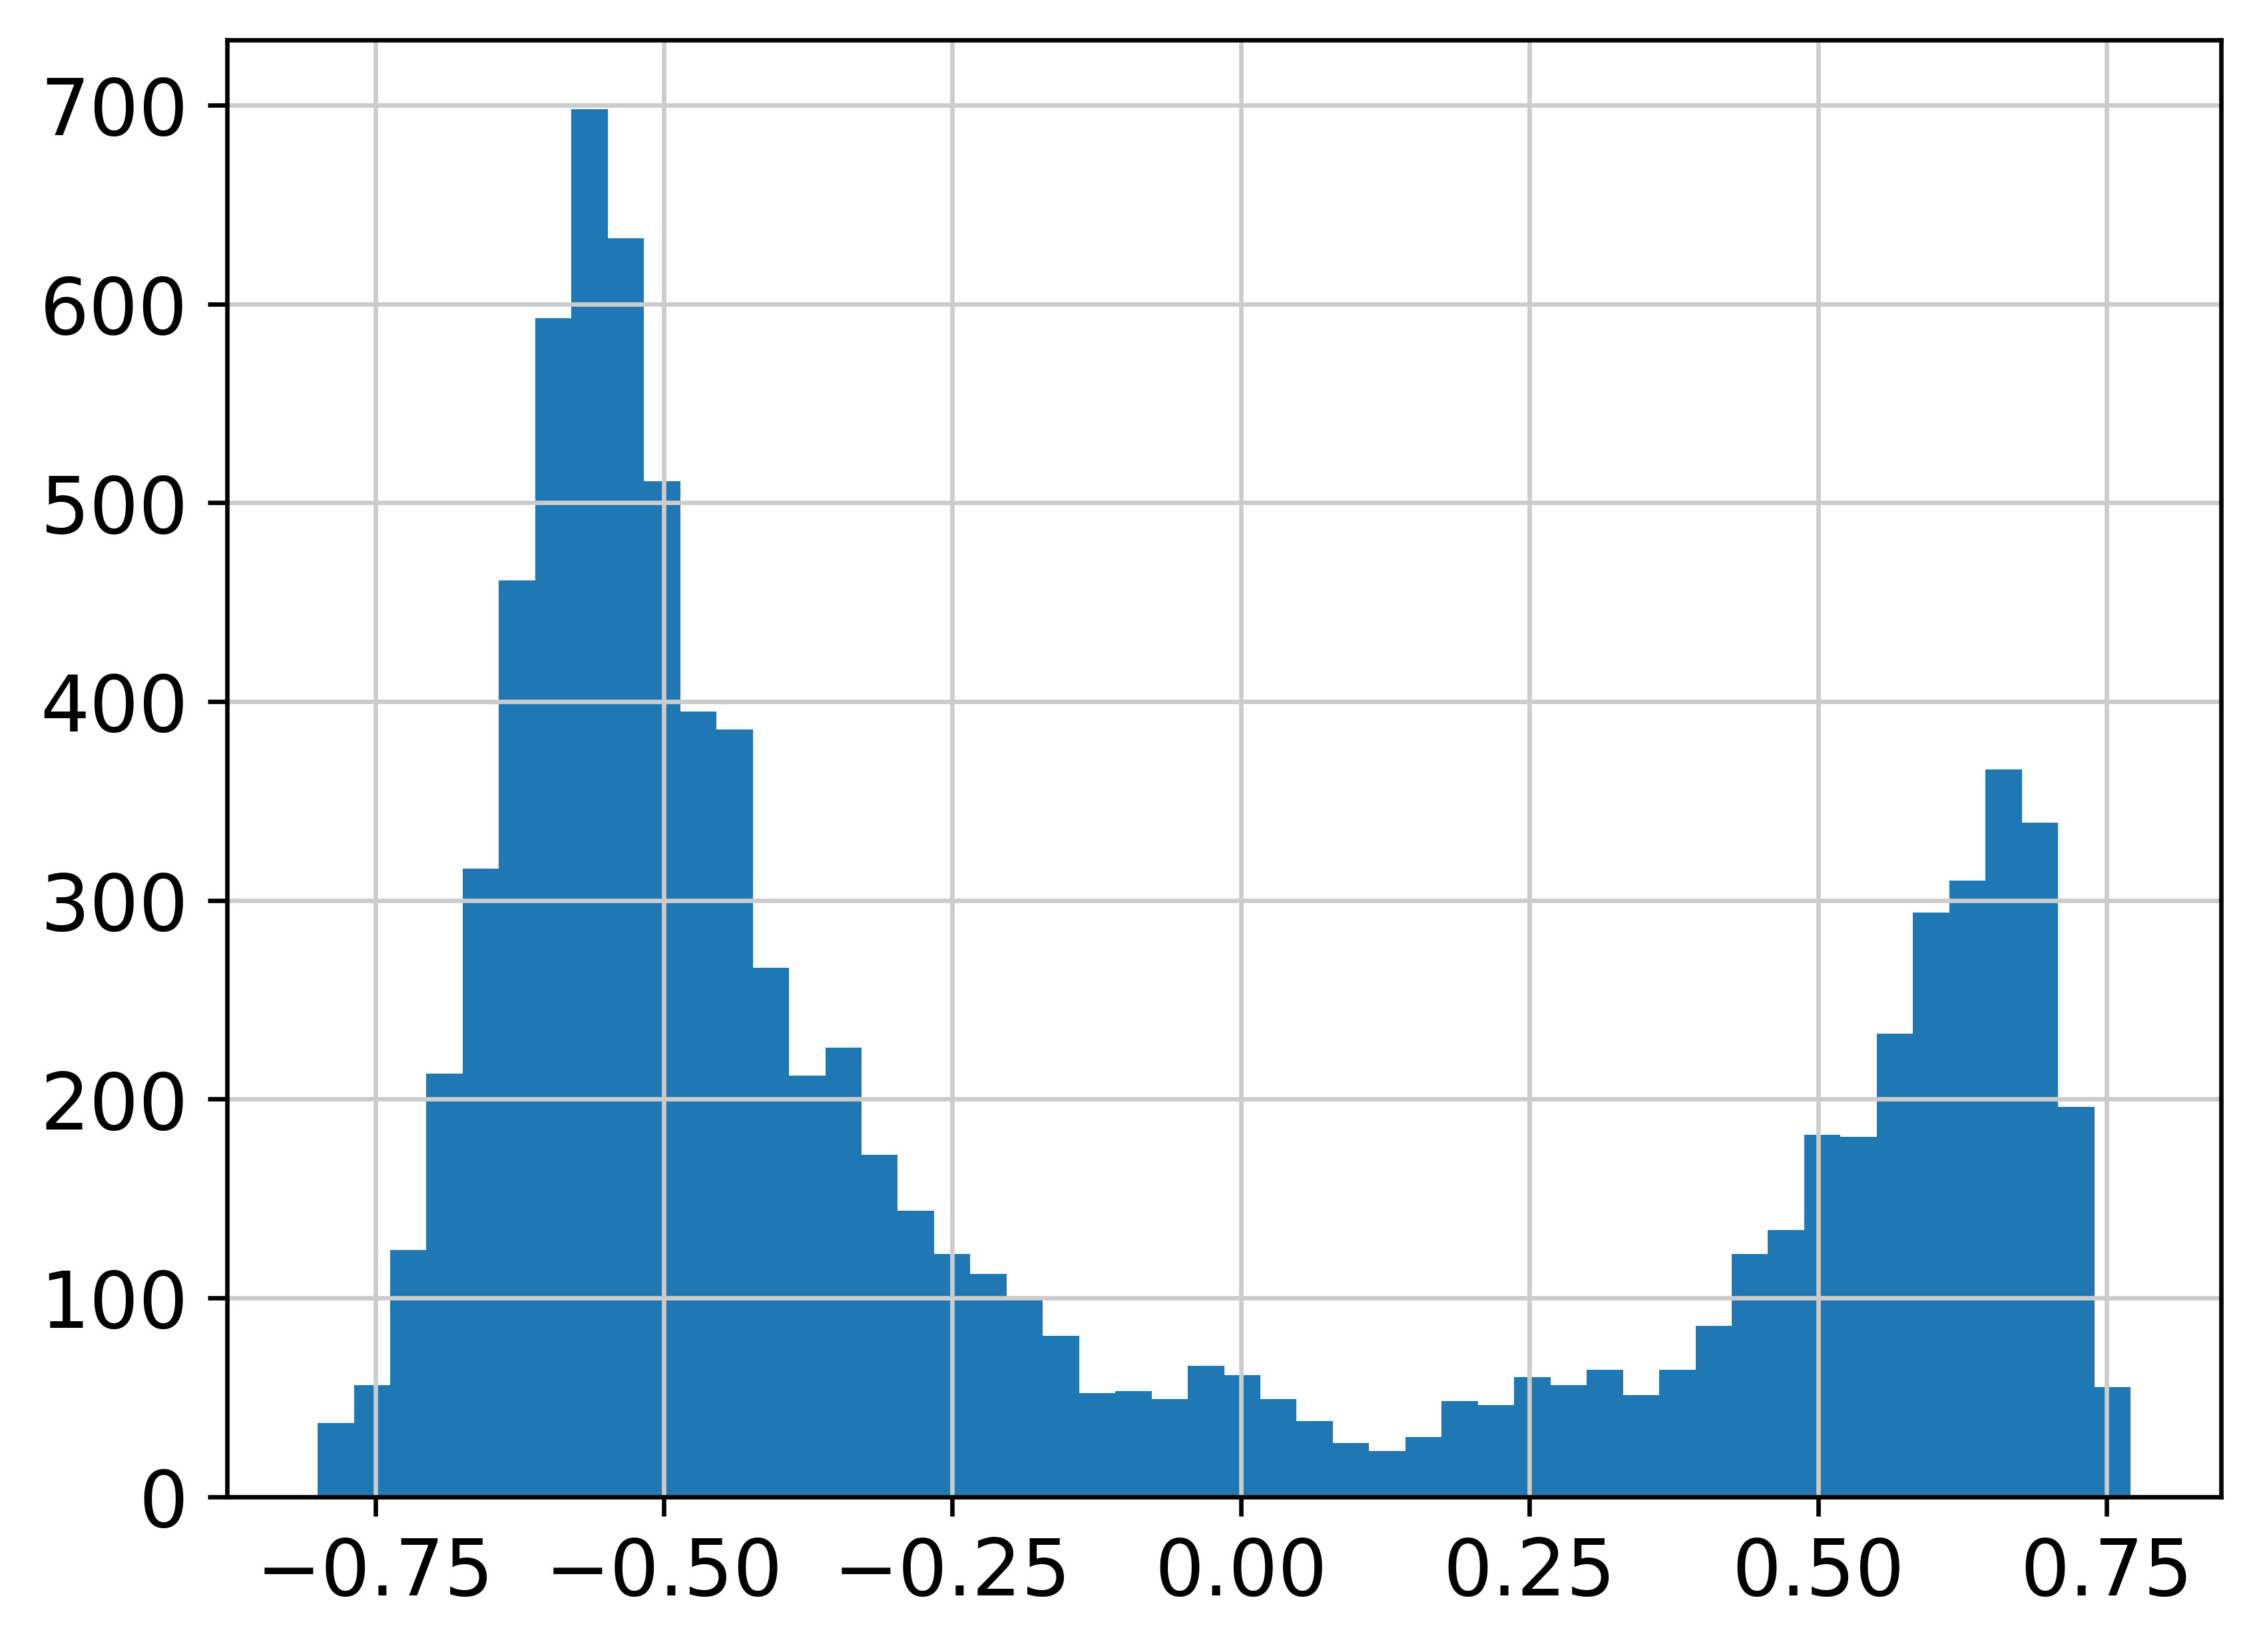

In [5]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/ImageSpot/')
import imagespot as ims
import seaborn as sns
ct_order = ['Capsular','Sub-Capsular','Cortical level I','Cortical level II','Cortical level III','Cortical CMJ','Medullar CMJ','Medullar level I','Medullar level II','Medullar level III']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette("tab20", len(ct_order)))[range(len(ct_order))]))
ct2_values = [-0.75,-0.62,-0.55,-0.45,-0.3,0.1,0.55,0.65,0.7]
adata_fet_cma.obs = ims.bin_axis(ct_order ,ct2_values,adata_fet_cma.obs,'cma_v2')   
adata_fet_cma.obs.loc[adata_fet_cma.obs['annotations_level_0']=='Edge','manual_bin_cma_v2'] = 'Capsular'
adata_fet_cma.obs['manual_bin_cma_v2'] = adata_fet_cma.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
adata_fet_cma.obs['manual_bin_cma_v2'].value_counts()
adata_fet_cma.obs['cma_v2'].hist(bins=50)
plt.show()

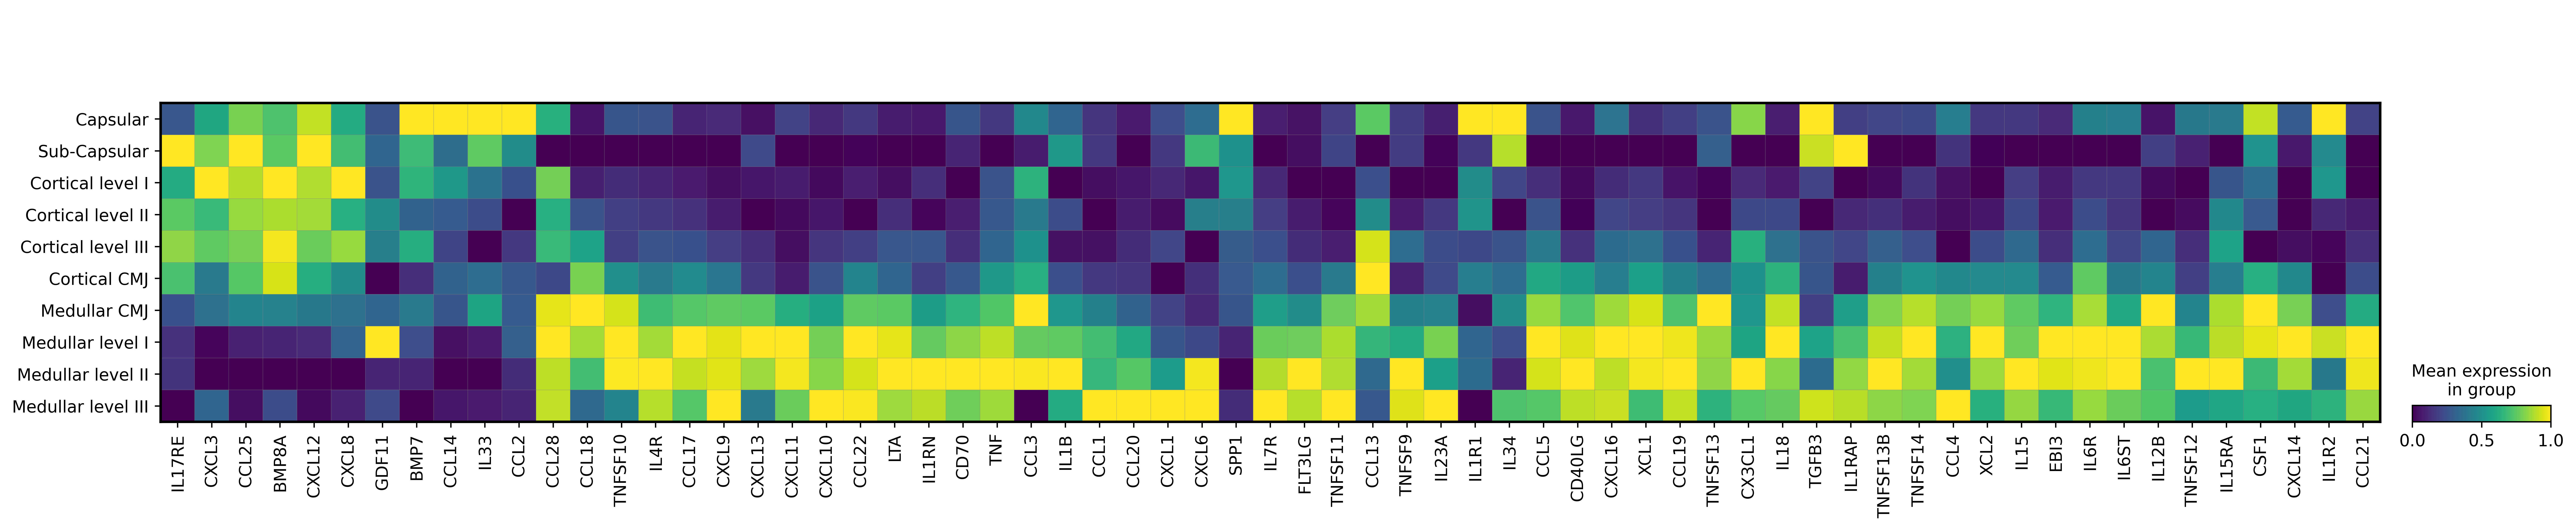

In [7]:
# Create matrix plot using scanpy
gene_order = np.load('/nfs/team205/ny1/ThymusSpatialAtlas/new_Figure3/cytokine_paed_list.npy').tolist()
sc.pl.matrixplot(adata_fet_cma,var_names=gene_order,groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',dendrogram=False)


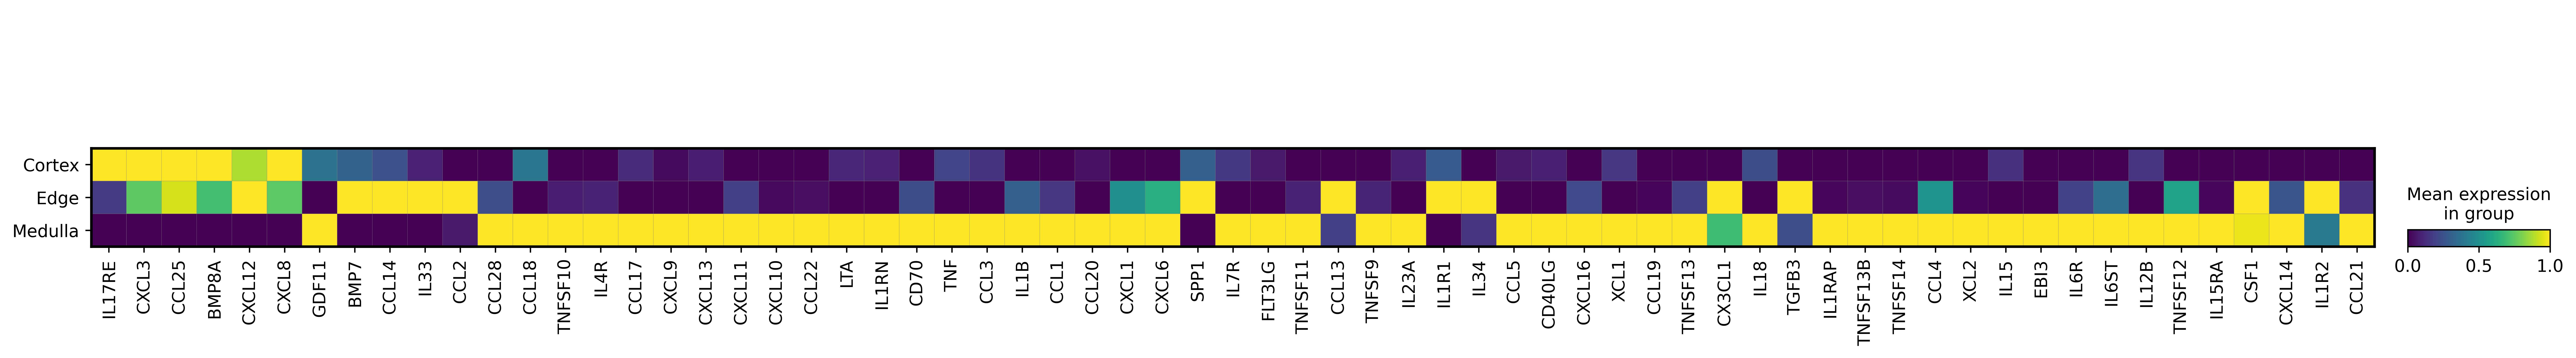

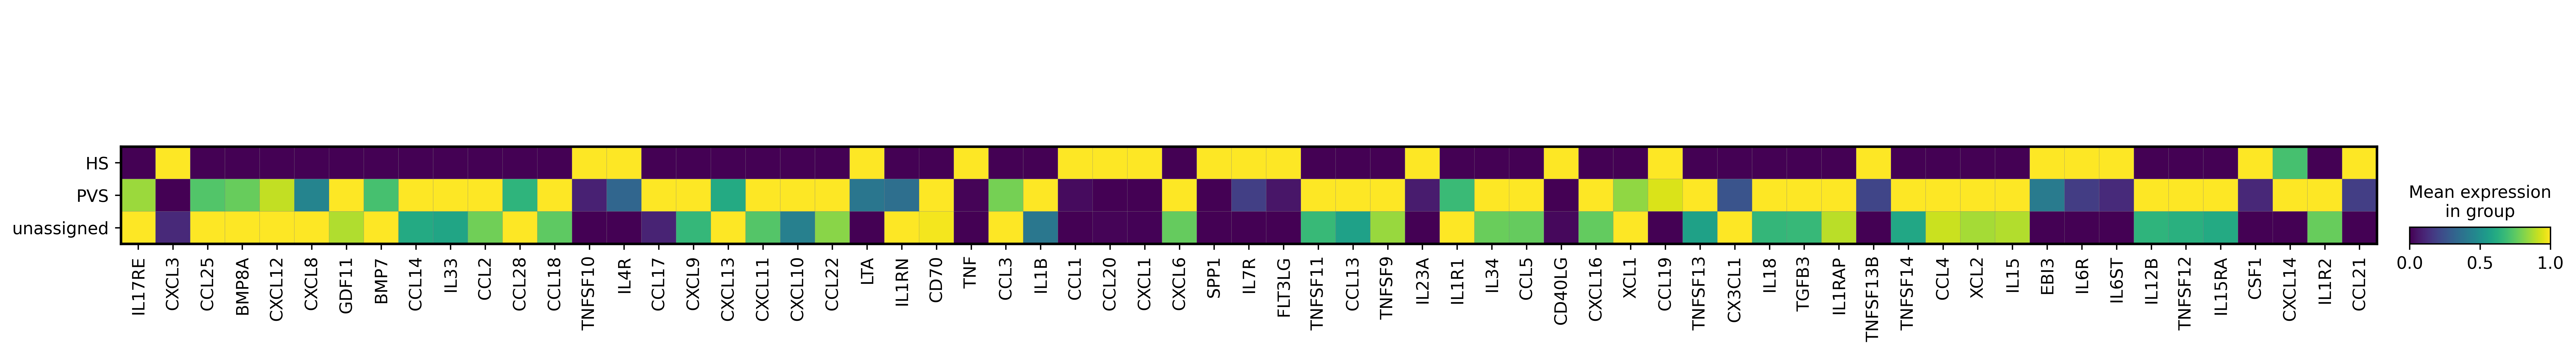

In [8]:
sc.pl.matrixplot(adata_fet_cma,var_names=gene_order,groupby='annotations_level_0',cmap='viridis',standard_scale='var',dendrogram=False)
sc.pl.matrixplot(adata_fet_cma,var_names=gene_order,groupby='annotations_level_1',cmap='viridis',standard_scale='var',dendrogram=False)


# Analyse cell level

In [9]:
celltypes = adata_fet_cma.uns['mod']['factor_names']
cellab_fet = sc.AnnData(adata_fet_cma.obs[celltypes], 
                         obs = adata_fet_cma.obs.drop(celltypes, axis = 1),obsm = adata_fet_cma.obsm)

cellab_fet.var_names
sc.pp.normalize_total(cellab_fet,target_sum=100)
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/new_Figure3/')


Index(['B-Prolif', 'B-memory', 'B-naive', 'B_pro_pre', 'CMP', 'DC1',
       'DC1-Prolif', 'DC2', 'DC2-Prolif', 'EC-Art', 'EC-Art-ELN', 'EC-Cap',
       'EC-Cap-Prolif', 'EC-Lymphatic', 'EC-Ven', 'EC-Ven-ELN', 'GMP',
       'InterloFb', 'InterloFb-COL9A3', 'Macrophage-APOC2', 'Macrophage-LYVE1',
       'Macrophage-SPIC1', 'Mast', 'Mesothelium', 'Monocyte_CCR2',
       'Monocyte_IL1B', 'Myelocyte', 'Neutrophil', 'Pericyte',
       'Pericyte_CCL19', 'Pericyte_COL1A1', 'PeriloFb', 'PeriloFb-Prolif',
       'ProlifPericyte', 'Promonocyte', 'RBC', 'SMC', 'Schwann',
       'TEC-cilliated', 'TEC-myo', 'TEC-neuro', 'TEC-tuft', 'T_CD4', 'T_CD8',
       'T_CD8-Prolif', 'T_CD8_memory', 'T_CD8αα(I)', 'T_CD8αα(II)',
       'T_CD8αα(entry)', 'T_DN(P)', 'T_DN(Q)', 'T_DN(early)', 'T_DP(P)',
       'T_DP(Q)', 'T_DP(Q)-CD99', 'T_DP(Q)-early', 'T_DP(Q)-late_vdj', 'T_ETP',
       'T_NK', 'T_NK_fetal', 'T_Treg(agonist)', 'T_Treg-diff_1',
       'T_Treg-diff_2', 'T_Treg_CD8', 'T_Treg_mature', 'T_Treg_recirc'

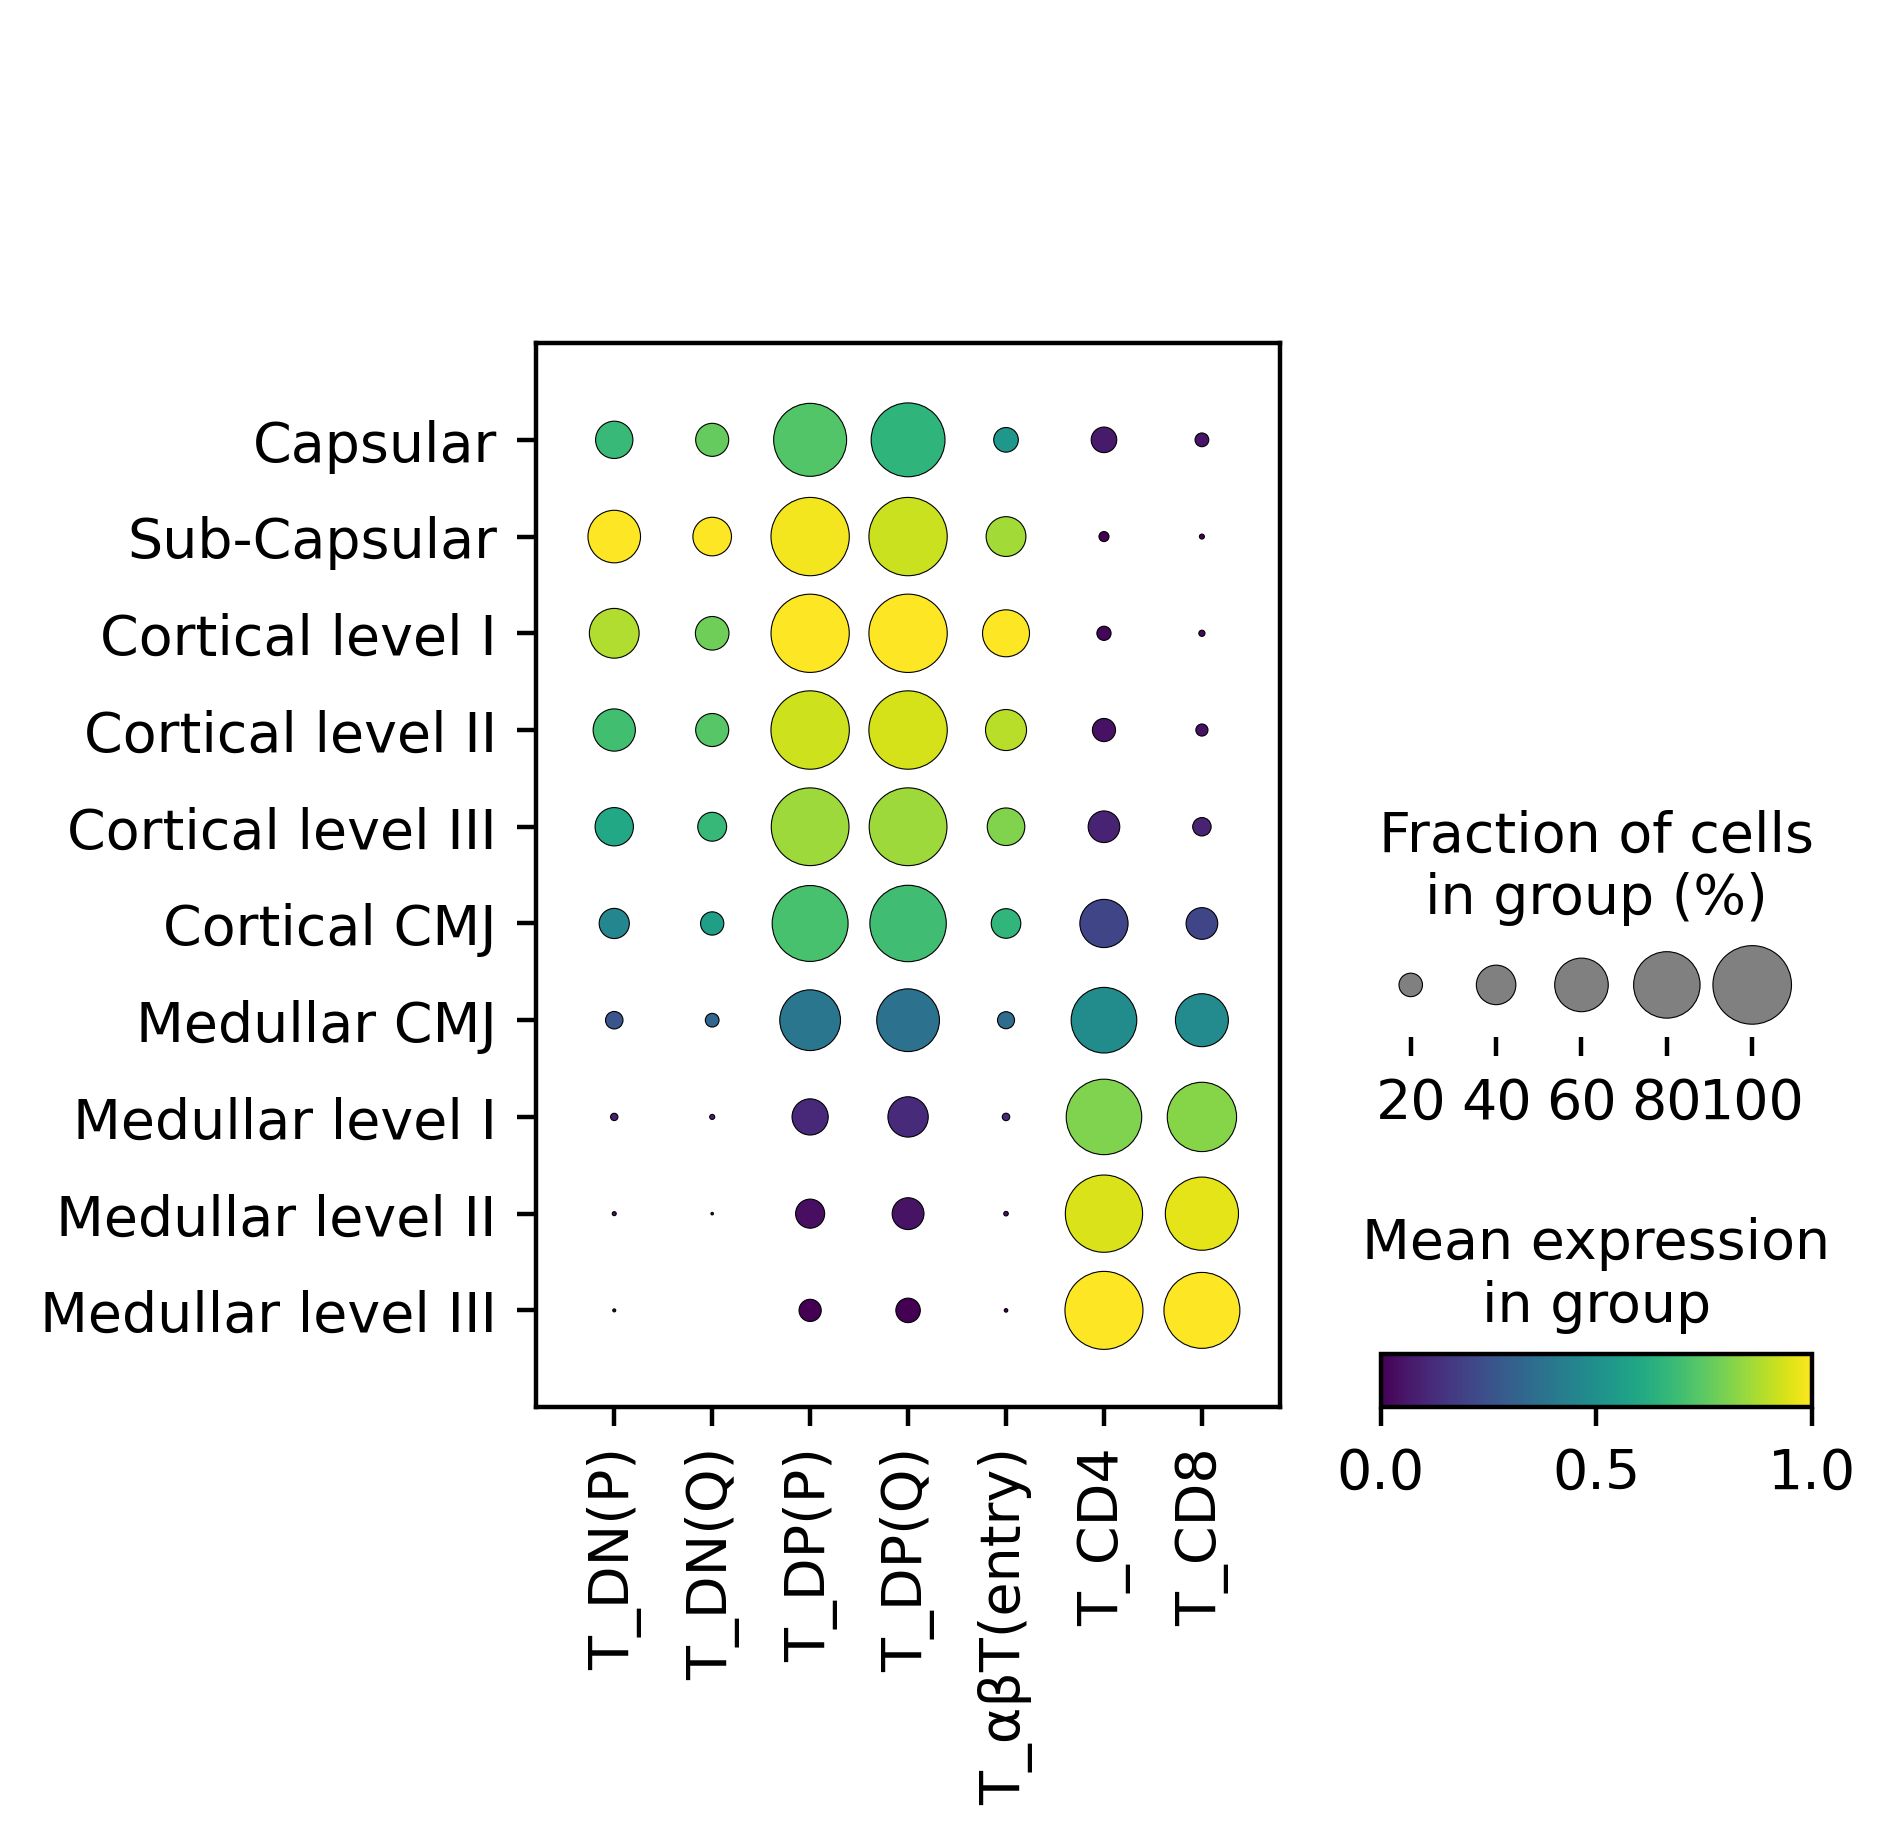

In [10]:
# cells = ['cTECII','cTECI','mcTEC-Prolif','mcTEC','mTECI','mTECII','mTECIII']
# cells = [ 'DC-a1', 'DC1', 'DC2','DC-a3']
# cells = ['T_reg(agonist)', 'T_reg(diff)-FOXP3Lo','T_reg(diff)-FOXP3hi','T_reg',]
# cells = ['B(P)', 'B(Q)', 'B-pro/pre']
# cells = ['PeriloFb','PeriloFb-Prolif','InterloFb', 'InterloFb-COL9A3', 'medFb-RGS5','medFb', 'medFb-CCL21']
cells = ['T_DN(P)', 'T_DN(Q)',
                 'T_DP(P)', 'T_DP(Q)',
                 'T_αβT(entry)', 'T_CD4', 'T_CD8']
# cells = ['ETP','T_DN(early)','T_DN(P)','T_DN(Q)-early','T_DN(Q)','T_DN(CD4)', 'T_DP(P)','T_DP(Q)','T_αβT(entry)','T_CD4', 'T_CD8',]
# cells = []
# cells = ['EC-Art','EC-Cap', 'EC-Cap-Prolif', 'EC-IFI44L', 'EC-Ven','EC-Ven-VCAN','Pericyte', 'Pericyte_COL1A1']
# cells = ['TEC-myo', 'TEC-neuro', 'TEC-cilliated','mTECI-trans']
# cells = ['T_NK','T_γδT','T_CD8αα(entry)','T_CD8αα(I)','T_CD8αα(II)']
cutoff = 2
sc.set_figure_params(figsize=[7,7],fontsize=12,dpi=200)
sc.pl.dotplot(cellab_fet,var_names=cells,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='fet_T_cutoff'+str(cutoff)+'.pdf')
              

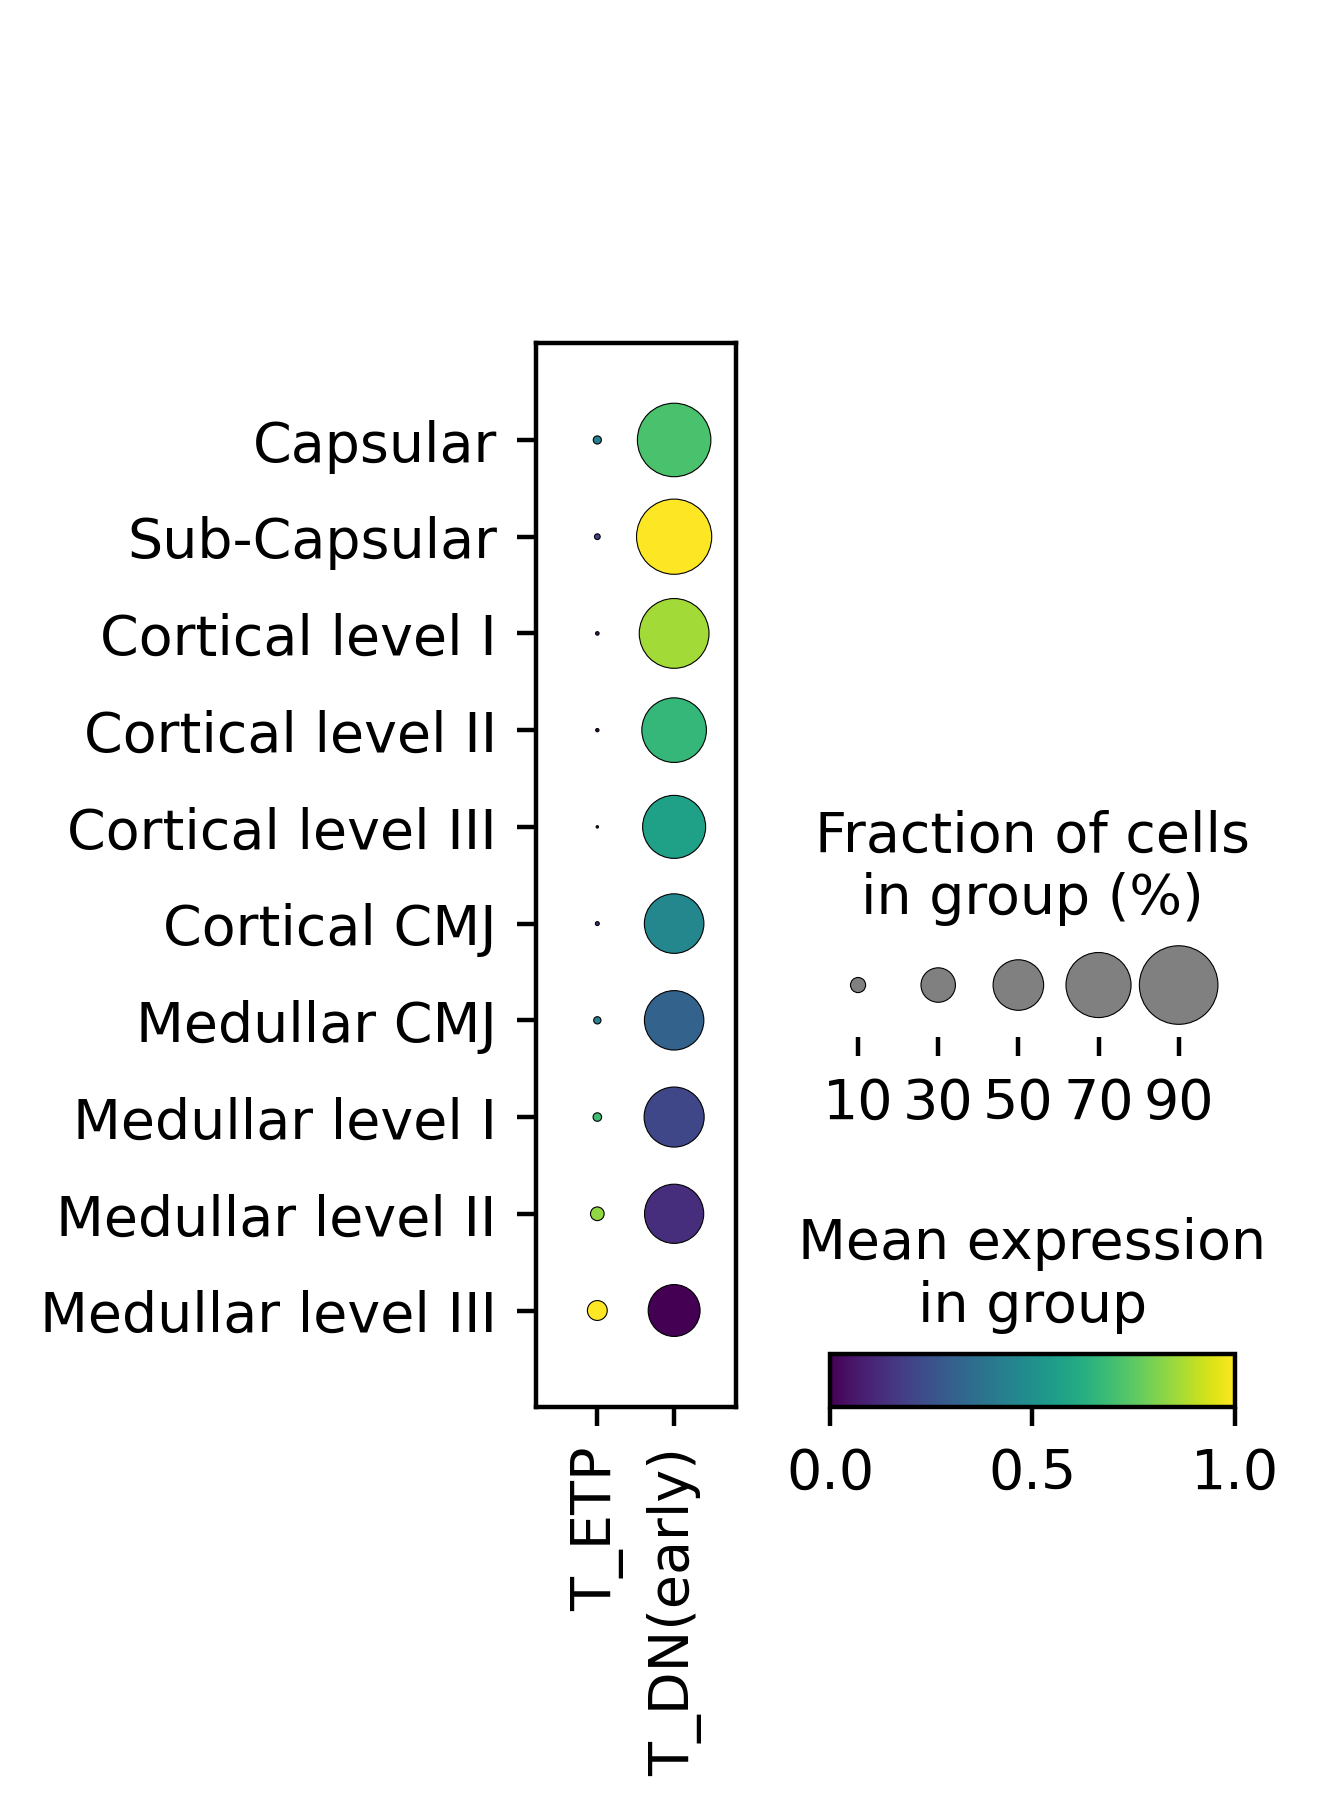

In [11]:
# cells = ['cTECII','cTECI','mcTEC-Prolif','mcTEC','mTECI','mTECII','mTECIII']
# cells = [ 'DC-a1', 'DC1', 'DC2','DC-a3']
# cells = ['T_reg(agonist)', 'T_reg(diff)-FOXP3Lo','T_reg(diff)-FOXP3hi','T_reg',]
# cells = ['B(P)', 'B(Q)', 'B-pro/pre']
# cells = ['PeriloFb','PeriloFb-Prolif','InterloFb', 'InterloFb-COL9A3', 'medFb-RGS5','medFb', 'medFb-CCL21']
cells = ['T_ETP','T_DN(early)']
# cells = ['ETP','T_DN(early)','T_DN(P)','T_DN(Q)-early','T_DN(Q)','T_DN(CD4)', 'T_DP(P)','T_DP(Q)','T_αβT(entry)','T_CD4', 'T_CD8',]
# cells = []
# cells = ['EC-Art','EC-Cap', 'EC-Cap-Prolif', 'EC-IFI44L', 'EC-Ven','EC-Ven-VCAN','Pericyte', 'Pericyte_COL1A1']
# cells = ['TEC-myo', 'TEC-neuro', 'TEC-cilliated','mTECI-trans']
# cells = ['T_NK','T_γδT','T_CD8αα(entry)','T_CD8αα(I)','T_CD8αα(II)']
cutoff = 0.2
sc.set_figure_params(figsize=[7,7],fontsize=12,dpi=200)
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/new_Figure3/')
sc.pl.dotplot(cellab_fet,var_names=cells,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='fet_etp_dn(early)_cutoff'+str(cutoff)+'.pdf')
              